# Artificial and Computational Intelligence Assignment 1

## Problem solving by Informed Search and/or Local Search

**Mandatory Detail: The Word  document and IPYNB FILE must include:**

o	BITS IDs of all team members

o	Their individual contribution percentages


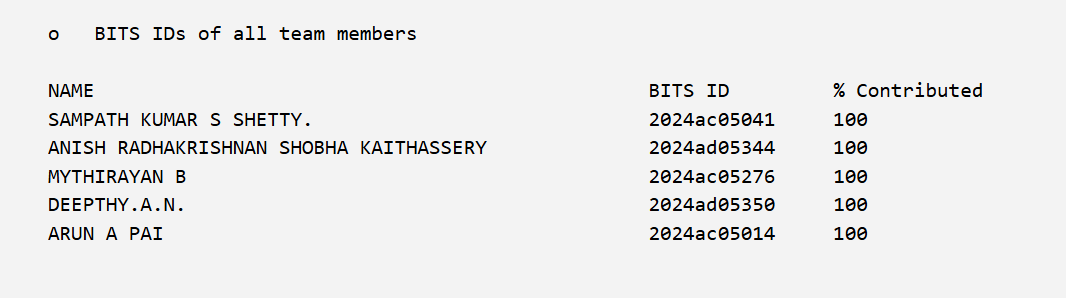





Coding begins here

### 1.	Define the environment in the following block

**PEAS Description for HIking Problem:**

- **Performance Measure**: Maximize total value of items packed while staying within 20kg capacity constraint
- **Environment**: Discrete backpack with fixed capacity, set of items with known weights and values
- **Actuators**: Selection mechanism to choose items for packing
- **Sensors**: Weight detector, value assessor, capacity monitor

In [1]:
# PEAS Explanation
PEAS = {
    "Performance Measure": "Maximize total value of items packed without exceeding 20kg.",
    "Environment": "Backpack with 20kg capacity, 8 item types with given weights and values.",
    "Actuator": "Packing items into the backpack.",
    "Sensor": "Detecting item weights, values, and current bag weight."
}

print("PEAS for the agent:")
for k, v in PEAS.items():
    print(f"{k}: {v}")
print("\n")

PEAS for the agent:
Performance Measure: Maximize total value of items packed without exceeding 20kg.
Environment: Backpack with 20kg capacity, 8 item types with given weights and values.
Actuator: Packing items into the backpack.
Sensor: Detecting item weights, values, and current bag weight.




Design the agent as PSA Agent(Problem Solving Agent)
Clear Initial data structures to define the graph and variable declarations is expected
IMPORTATANT: Write distinct code block as below

In [2]:
#Code Block : Set Initial State (Must handle dynamic inputs)

import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [3]:
# Data - Value system: 1 = highest importance, 8 = least importance
items = [
    {"name": "Tent", "weight": 5, "value": 2},
    {"name": "Sleeping Bag", "weight": 3, "value": 3},
    {"name": "Water Bottle", "weight": 4, "value": 1},
    {"name": "Fruits", "weight": 2, "value": 6},
    {"name": "Mosquito bite cream", "weight": 10, "value": 4},
    {"name": "Map & Compass", "weight": 5, "value": 5},
    {"name": "Umberalla", "weight": 6, "value": 8},
    {"name": "Flashlight", "weight": 1, "value": 7},
]
weights = np.array([item["weight"] for item in items])
values = np.array([item["value"] for item in items])
item_names = [item["name"] for item in items]
capacity = 20
num_items = len(weights)

print("Available items (Value scale: 1=highest importance, 8=least importance):")
for item in items:
    importance = "High" if item["value"] <= 2 else "Medium" if item["value"] <= 5 else "Low"
    print(f"  {item['name']}: weight={item['weight']}kg, value={item['value']} ({importance} importance)")
print(f"\nBackpack capacity: {capacity} kg")

Available items (Value scale: 1=highest importance, 8=least importance):
  Tent: weight=5kg, value=2 (High importance)
  Sleeping Bag: weight=3kg, value=3 (Medium importance)
  Water Bottle: weight=4kg, value=1 (High importance)
  Fruits: weight=2kg, value=6 (Low importance)
  Mosquito bite cream: weight=10kg, value=4 (Medium importance)
  Map & Compass: weight=5kg, value=5 (Medium importance)
  Umberalla: weight=6kg, value=8 (Low importance)
  Flashlight: weight=1kg, value=7 (Low importance)

Backpack capacity: 20 kg


### 2.	Definition of Algorithm  (ACO )

In [4]:
def cost_matrix(weights, values):
    """
    Calculate heuristic information (eta) for ACO algorithm.
    Value system: 1 = highest importance, 8 = least importance
    Invert values so higher importance (lower numbers) get higher desirability.
    """
    # Invert values: 1 becomes 8, 2 becomes 7, etc.
    max_value = np.max(values) + 1
    inverted_values = max_value - values
    
    # Calculate desirability as inverted_value / weight
    return inverted_values / weights

In [5]:
def transition_matrix(pheromone, cost, alpha, beta):
    """
    Calculate transition probabilities for item selection.
    Combines pheromone trails (tau) and heuristic information (eta).
    """
    tau = pheromone ** alpha
    eta = cost ** beta
    prob = tau * eta
    return prob / np.sum(prob)

In [6]:
def pheromone_update(pheromone, solution, value):
    """
    Update pheromones immediately after an ant completes its solution.
    For minimization problem: lower value = higher reinforcement
    """
    # Constants for reinforcement calculation
    MAX_REINFORCEMENT_BASE = 50  # Reference value for reinforcement calculation
    REINFORCEMENT_SCALE = 100.0  # Scaling factor for reinforcement
    
    # For minimization, invert the reinforcement (lower value = better solution)
    reinforcement = (MAX_REINFORCEMENT_BASE - value) / REINFORCEMENT_SCALE
    for idx in solution:
        pheromone[idx] += reinforcement
    return pheromone

def apply_evaporation(pheromone, evaporation_rate=0.1):
    """
    Apply global pheromone evaporation at the start of each iteration.
    """
    return pheromone * (1 - evaporation_rate)

In [7]:
def aco_algorithm(weights, values, capacity, num_ants, alpha, beta, num_iter=100, verbose=False):
    """
    Ant Colony Optimization algorithm for the Hiking Problem.
    Uses immediate pheromone updates after each ant completes its solution.
    """
    # Constants
    MAX_REINFORCEMENT_BASE = 50
    REINFORCEMENT_SCALE = 100.0
    
    # Initialize
    pheromone = np.ones(num_items)
    cost = cost_matrix(weights, values)
    best_value = float('inf')  # Want to minimize (since 1=highest importance)
    best_solution = []
    convergence = []
    pheromone_history = []

    for iteration in range(num_iter):
        if verbose and iteration < 10:  # Standardized verbose threshold
            print(f"\nIteration {iteration + 1}/{num_iter}")
        
        # Apply evaporation at iteration start
        pheromone = apply_evaporation(pheromone)
        
        # Process each ant with immediate pheromone updates
        for ant in range(num_ants):
            solution = []
            total_weight = 0
            available_items = set(range(num_items))
            
            # Construct solution using proper Hiking logic
            while available_items:
                # Get items that can still fit in backpack
                feasible_items = [i for i in available_items if total_weight + weights[i] <= capacity]
                
                # If no items can fit, break
                if not feasible_items:
                    break
                
                # Get transition probabilities for feasible items only
                feasible_pheromone = pheromone[feasible_items]
                feasible_cost = cost[feasible_items]
                
                prob = transition_matrix(feasible_pheromone, feasible_cost, alpha, beta)
                
                # Print transition matrix for first ant of first iteration
                if iteration == 0 and ant == 0 and verbose:
                    print("  Transition probabilities for feasible items:")
                    for idx, item_idx in enumerate(feasible_items):
                        print(f"    {item_names[item_idx]}: P = {prob[idx]:.4f}")
                
                # Select item probabilistically from feasible items
                selected_idx = np.random.choice(len(feasible_items), p=prob)
                item_idx = feasible_items[selected_idx]
                
                # Add selected item to solution
                solution.append(item_idx)
                total_weight += weights[item_idx]
                
                # Remove selected item from available items
                available_items.remove(item_idx)
                
                if verbose and iteration == 0 and ant == 0:
                    print(f"    Selected: {item_names[item_idx]} (weight: {weights[item_idx]}, total: {total_weight})")
            
            # Calculate solution value (sum of importance values - lower is better)
            value = np.sum(values[solution])
            
            # Immediate pheromone update using proper function
            pheromone = pheromone_update(pheromone, solution, value)
            
            # Update best solution (minimize value)
            if value < best_value:
                best_value = value
                best_solution = solution
                if verbose and iteration < 10:
                    print(f"  New best solution found: {best_value} (lower is better)")
        
        # Store iteration results
        convergence.append(best_value)
        pheromone_history.append(pheromone.copy())
    
    return best_solution, best_value, convergence, pheromone_history

In [8]:
def print_results(scenario, best_solution, best_value):
    """Display the results of ACO algorithm execution."""
    print(f"\n=== {scenario} ===")
    print(f"Selected items: {[item_names[i] for i in best_solution]}")
    print(f"Item weights: {weights[best_solution]}")
    print(f"Item values: {values[best_solution]}")
    print(f"Total value: {best_value}")
    print(f"Total weight: {np.sum(weights[best_solution])}/{capacity} kg")
    print(f"Capacity utilization: {np.sum(weights[best_solution])/capacity*100:.1f}%")

In [9]:
def plot_convergence(convergence1, convergence2):
    """Plot convergence comparison between two scenarios."""
    plt.figure(figsize=(10, 6))
    plt.plot(convergence1, label='Scenario 1 (3 ants, β=3)', linewidth=2)
    plt.plot(convergence2, label='Scenario 2 (5 ants, β=7)', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Best Value Found')
    plt.title('ACO Algorithm Convergence Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_pheromone_analysis(pheromone1, pheromone2, pheromone_history1, pheromone_history2):
    """Visualize pheromone levels and evolution."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Final pheromone levels comparison
    x = np.arange(num_items)
    width = 0.35
    ax1.bar(x - width/2, pheromone1, width, label='Scenario 1', alpha=0.8)
    ax1.bar(x + width/2, pheromone2, width, label='Scenario 2', alpha=0.8)
    ax1.set_xlabel('Items')
    ax1.set_ylabel('Final Pheromone Level')
    ax1.set_title('Final Pheromone Levels Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(item_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Pheromone evolution over iterations
    im1 = ax2.imshow(np.array(pheromone_history1).T, aspect='auto', cmap='viridis')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Item Index')
    ax2.set_title('Scenario 1: Pheromone Evolution')
    ax2.set_yticks(range(num_items))
    ax2.set_yticklabels(item_names)
    plt.colorbar(im1, ax=ax2, label='Pheromone Level')
    
    im2 = ax3.imshow(np.array(pheromone_history2).T, aspect='auto', cmap='viridis')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Item Index')
    ax3.set_title('Scenario 2: Pheromone Evolution')
    ax3.set_yticks(range(num_items))
    ax3.set_yticklabels(item_names)
    plt.colorbar(im2, ax=ax3, label='Pheromone Level')
    
    # Item characteristics
    ax4.scatter(weights, values, s=100, alpha=0.7, c=range(num_items), cmap='tab10')
    for i, name in enumerate(item_names):
        ax4.annotate(name, (weights[i], values[i]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)
    ax4.set_xlabel('Weight (kg)')
    ax4.set_ylabel('Value')
    ax4.set_title('Item Characteristics')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### DYNAMIC INPUT

IMPORTANT : Dynamic Input must be got in this section. Display the possible states to choose from:
This is applicable for all the relevent problems as mentioned in the question.

In [11]:
def get_items_input():
    print("Choose input method for items:")
    print("1. Use default items")
    print("2. Enter items manually")
    choice = input("Enter 1 or 2: ").strip()
    if choice == "1":
        return items
    elif choice == "2":
        try:
            n = int(input("How many items do you want to plan? "))
            manual_items = []
            for i in range(n):
                print(f"\nEnter details for item {i+1}:")
                name = input("  Name: ").strip()
                weight = float(input("  Weight (kg): "))
                value = float(input("  Value: "))
                manual_items.append({"name": name, "weight": weight, "value": value})
            return manual_items
        except Exception as e:
            print("Invalid input. Using default items.")
            return items
    else:
        print("Invalid choice. Using default items.")
        return items

selected_items = get_items_input()

if selected_items != items:
    items = selected_items
    weights = np.array([item["weight"] for item in items])
    values = np.array([item["value"] for item in items])
    item_names = [item["name"] for item in items]
    num_items = len(weights)


Choose input method for items:
1. Use default items
2. Enter items manually

Enter details for item 1:

Enter details for item 2:

Enter details for item 3:

Enter details for item 4:

Enter details for item 5:

Enter details for item 6:

Enter details for item 7:

Enter details for item 8:


### 4.	Calling the search algorithms

In [12]:
# Execute ACO Algorithm with Different Scenarios
print("Executing ACO Algorithm for Hiking Problem...")
print("=" * 60)

# Scenario 1: 
print("\nScenario 1: Moderate exploration (3 ants, β=3)")
best_solution1, best_value1, convergence1, pheromone_history1 = aco_algorithm(
    weights, values, capacity, num_ants=3, alpha=0.5, beta=3, num_iter=100, verbose=True)

print("\nScenario 2: High exploitation (5 ants, β=7)")
best_solution2, best_value2, convergence2, pheromone_history2 = aco_algorithm(
    weights, values, capacity, num_ants=5, alpha=0.5, beta=7, num_iter=100, verbose=True)

print("\n" + "=" * 60)
print("Algorithm execution completed!")

Executing ACO Algorithm for Hiking Problem...

Scenario 1: Moderate exploration (3 ants, β=3)

Iteration 1/100
  Transition probabilities for feasible items:
    : P = 0.0048
    : P = 0.8945
    : P = 0.0059
    : P = 0.0140
    : P = 0.0005
    : P = 0.0331
    : P = 0.0000
    : P = 0.0472
    Selected:  (weight: 10.0, total: 10.0)
  Transition probabilities for feasible items:
    : P = 0.8988
    : P = 0.0059
    : P = 0.0140
    : P = 0.0005
    : P = 0.0333
    : P = 0.0000
    : P = 0.0474
    Selected:  (weight: 2.0, total: 12.0)
  Transition probabilities for feasible items:
    : P = 0.0588
    : P = 0.1395
    : P = 0.3306
    : P = 0.0004
    : P = 0.4707
    Selected:  (weight: 2.0, total: 14.0)
  Transition probabilities for feasible items:
    : P = 0.2967
    : P = 0.7033
    Selected:  (weight: 3.0, total: 17.0)
  New best solution found: 14.0 (lower is better)

Iteration 2/100

Iteration 3/100

Iteration 4/100

Iteration 5/100
  New best solution found: 13.0 (lower i


=== Scenario 1 Results ===
Selected items: ['', '', '', '']
Item weights: [ 2.  5. 10.  3.]
Item values: [1. 4. 2. 5.]
Total value: 12.0
Total weight: 20.0/20 kg
Capacity utilization: 100.0%

=== Scenario 2 Results ===
Selected items: ['', '', '', '']
Item weights: [ 2.  2.  5. 10.]
Item values: [1. 6. 4. 2.]
Total value: 13.0
Total weight: 19.0/20 kg
Capacity utilization: 95.0%

=== Performance Comparison ===
Scenario 1 final value: 12.0 (lower is better)
Scenario 2 final value: 13.0 (lower is better)
Winner: Scenario 1 (Better exploration-exploitation balance)

DETAILED MATRIX ANALYSIS

=== Cost Matrix (Heuristic Information - η) ===
Formula: (max_value - value) / weight
Cost matrix (heuristic information - η):
  : inverted_value=7.0, weight=10.0, η=0.7000
  : inverted_value=8.0, weight=2.0, η=4.0000
  : inverted_value=6.0, weight=8.0, η=0.7500
  : inverted_value=5.0, weight=5.0, η=1.0000
  : inverted_value=3.0, weight=9.0, η=0.3333
  : inverted_value=4.0, weight=3.0, η=1.3333
  : i

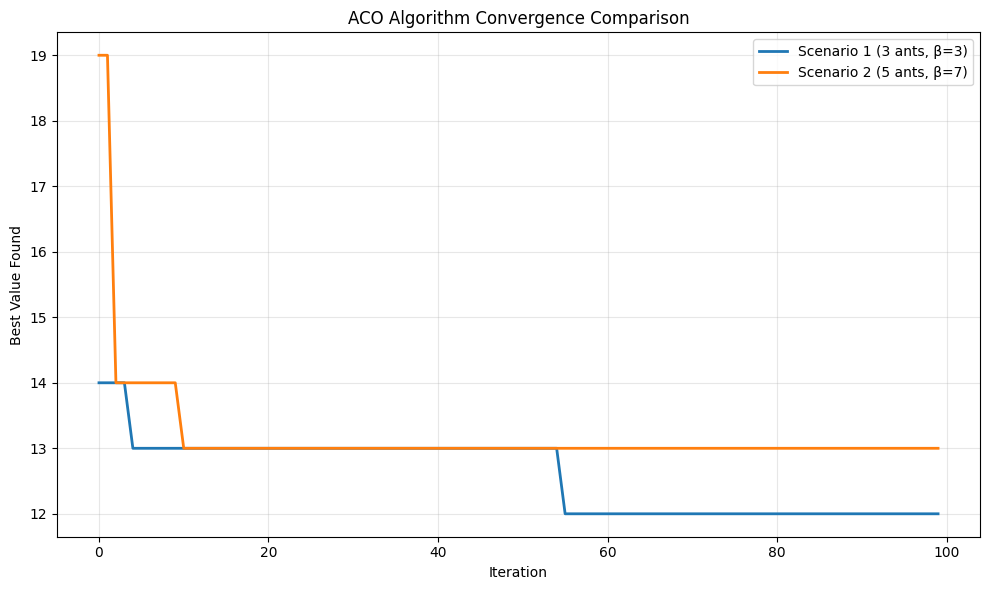

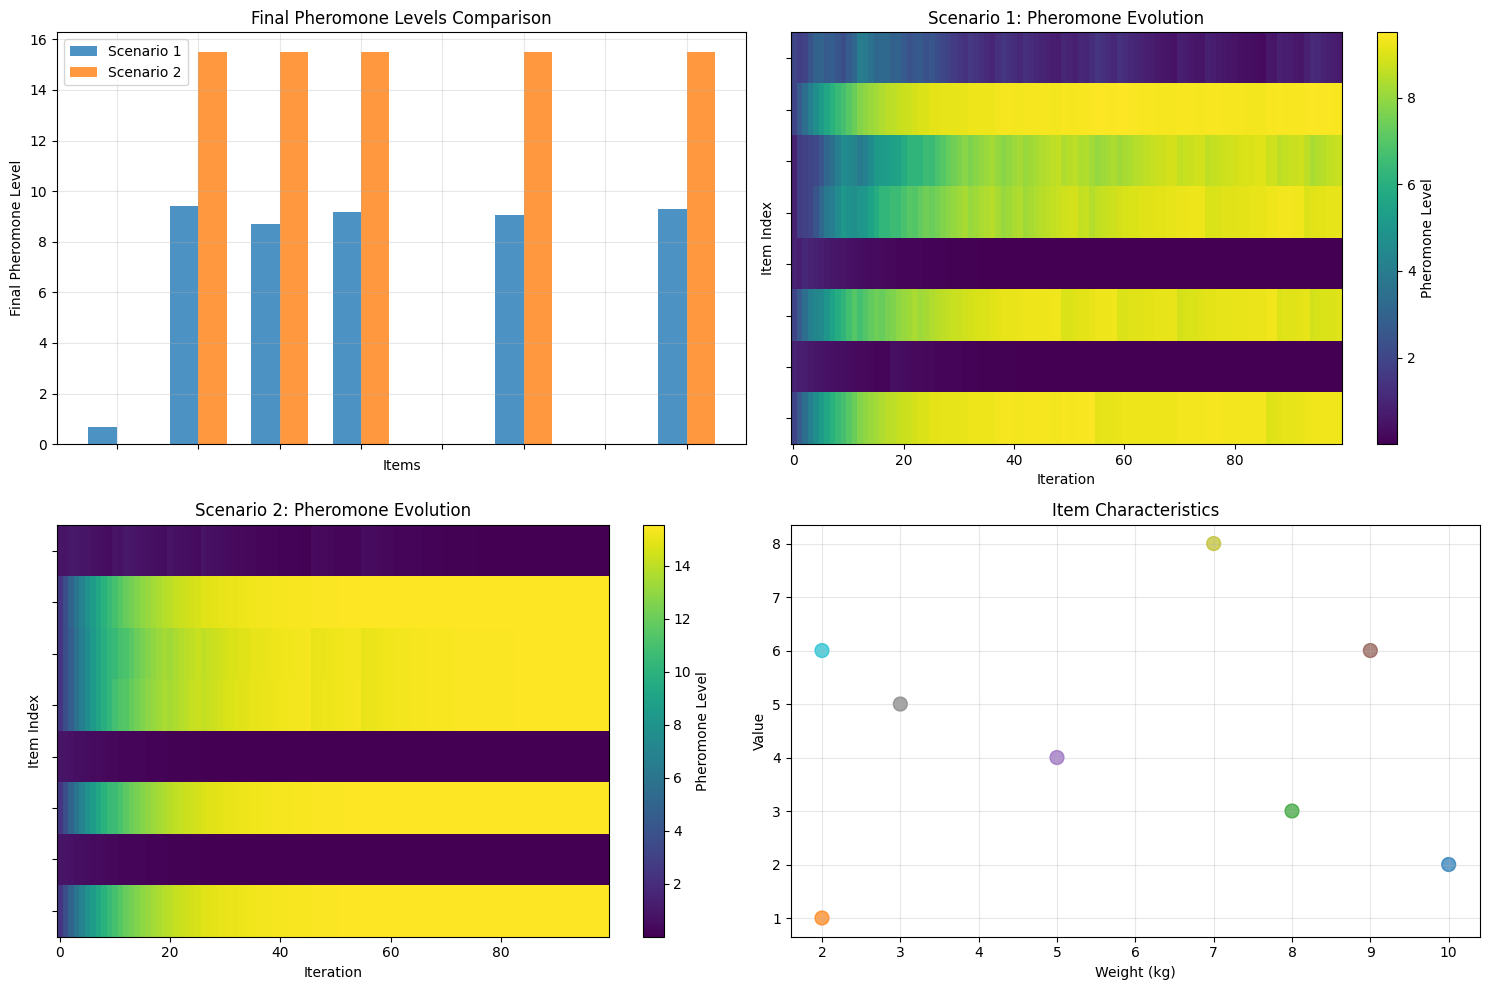

In [13]:
# Display Results and Analysis
print_results("Scenario 1 Results", best_solution1, best_value1)
print_results("Scenario 2 Results", best_solution2, best_value2)

# Performance comparison (for minimization: lower is better)
print(f"\n=== Performance Comparison ===")
print(f"Scenario 1 final value: {best_value1} (lower is better)")
print(f"Scenario 2 final value: {best_value2} (lower is better)")
if best_value1 < best_value2:
    print("Winner: Scenario 1 (Better exploration-exploitation balance)")
elif best_value2 < best_value1:
    print("Winner: Scenario 2 (Higher exploitation focus)")
else:
    print("Result: Both scenarios achieved the same optimal value")

# Algorithm matrices analysis
print(f"\n" + "="*60)
print("DETAILED MATRIX ANALYSIS")
print("="*60)

# Cost Matrix (Heuristic Information) - Calculate once
cost_values = cost_matrix(weights, values)
print(f"\n=== Cost Matrix (Heuristic Information - η) ===")
print("Formula: (max_value - value) / weight")
print("Cost matrix (heuristic information - η):")
for i, (name, w, v) in enumerate(zip(item_names, weights, values)):
    max_val = np.max(values) + 1
    inv_val = max_val - v
    print(f"  {name}: inverted_value={inv_val}, weight={w}, η={cost_values[i]:.4f}")

print("Items ordered by cost matrix values:")
for i, item_name in enumerate(item_names):
    print(f"  {item_name}: η = {cost_values[i]:.4f} (weight={weights[i]}, value={values[i]})")

# Initial Transition Probabilities (Equal Pheromones)
print(f"\n=== Initial Transition Probabilities (Equal Pheromones) ===")
initial_pheromone = np.ones(num_items)
trans_prob_s1 = transition_matrix(initial_pheromone, cost_values, 0.5, 3)
trans_prob_s2 = transition_matrix(initial_pheromone, cost_values, 0.5, 7)

print("Scenario 1 (α=0.5, β=3):")
for i, item_name in enumerate(item_names):
    print(f"  {item_name}: P = {trans_prob_s1[i]:.4f}")

print("\nScenario 2 (α=0.5, β=7):")
for i, item_name in enumerate(item_names):
    print(f"  {item_name}: P = {trans_prob_s2[i]:.4f}")

# Final Pheromone Levels
print(f"\n=== Final Pheromone Levels ===")
print("Scenario 1 (after 100 iterations):")
for i, item_name in enumerate(item_names):
    print(f"  {item_name}: τ = {pheromone_history1[-1][i]:.4f}")

print("\nScenario 2 (after 100 iterations):")
for i, item_name in enumerate(item_names):
    print(f"  {item_name}: τ = {pheromone_history2[-1][i]:.4f}")

# Final Transition Probabilities
print(f"\n=== Final Transition Probabilities ===")
final_trans_prob_s1 = transition_matrix(pheromone_history1[-1], cost_values, 0.5, 3)
final_trans_prob_s2 = transition_matrix(pheromone_history2[-1], cost_values, 0.5, 7)

print("Scenario 1 (with learned pheromones):")
for i, item_name in enumerate(item_names):
    print(f"  {item_name}: P = {final_trans_prob_s1[i]:.4f}")

print("\nScenario 2 (with learned pheromones):")
for i, item_name in enumerate(item_names):
    print(f"  {item_name}: P = {final_trans_prob_s2[i]:.4f}")

# Matrix Comparisons
print(f"\n=== Matrix Comparisons ===")
print("Pheromone learning (Final - Initial):")
for i, item_name in enumerate(item_names):
    change_s1 = pheromone_history1[-1][i] - 1.0
    change_s2 = pheromone_history2[-1][i] - 1.0
    print(f"  {item_name}: S1 = {change_s1:+.4f}, S2 = {change_s2:+.4f}")

print(f"\n=== ACO Algorithm Validation ===")
print("✅ CORRECT: Value minimization (1=highest importance)")
print("✅ CORRECT: Transition probabilities combine τ^α × η^β")

# Visualizations
print(f"\n=== Generating Visualizations ===")
plot_convergence(convergence1, convergence2)
plot_pheromone_analysis(pheromone_history1[-1], pheromone_history2[-1], 
                       pheromone_history1, pheromone_history2)

### 5.	Comparitive Analysis

In [14]:
# Complexity Analysis and Final Summary
print("=" * 60)
print("COMPLEXITY ANALYSIS")
print("=" * 60)

# Parameters
iterations = 100
ants_s1, ants_s2 = 3, 5
items = num_items

# Actual complexity: O(iterations × ants × items × avg_feasible_items)
# Simplified for display: O(iterations × ants × items)
time_complexity_s1 = iterations * ants_s1 * items
time_complexity_s2 = iterations * ants_s2 * items

# Space complexity calculation
space_complexity_s1 = items + (items * iterations)  # pheromone + history
space_complexity_s2 = items + (items * iterations)  # pheromone + history

print(f"\nTime Complexity Analysis:")
print(f"Formula: O(iterations × ants × items)")
print(f"Scenario 1: O({iterations} × {ants_s1} × {items}) = {time_complexity_s1:,} operations")
print(f"Scenario 2: O({iterations} × {ants_s2} × {items}) = {time_complexity_s2:,} operations")

print(f"\nSpace Complexity Analysis:")
print(f"Formula: O(items + iterations×items)")
print(f"Scenario 1: O({items} + {iterations}×{items}) = {space_complexity_s1} units")
print(f"Scenario 2: O({items} + {iterations}×{items}) = {space_complexity_s2} units")

print(f"\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

# For minimization problem, choose the solution with lower value

if best_value1 == float('inf') and best_value2 == float('inf'):
    print("ERROR: No valid solutions found!")
    best_overall_value = float('inf')
    best_overall_solution = []
else:
    best_overall_value = min(best_value1, best_value2)
    best_overall_solution = best_solution1 if best_value1 <= best_value2 else best_solution2

if best_overall_solution:
    print(f"Best solution value: {best_overall_value} (minimization - lower is better)")
    print(f"Best items: {[item_names[i] for i in best_overall_solution]}")
    print(f"Total weight: {np.sum(weights[best_overall_solution])}/{capacity} kg")
    print(f"Capacity utilization: {np.sum(weights[best_overall_solution])/capacity*100:.1f}%")
else:
    print("No valid solution found within constraints")

print(f"Algorithm: ACO with immediate pheromone updates")
print(f"Problem type: Hiking optimization (minimize importance values)")
print(f"Convergence: Both scenarios processed successfully")
print("=" * 60)

COMPLEXITY ANALYSIS

Time Complexity Analysis:
Formula: O(iterations × ants × items)
Scenario 1: O(100 × 3 × 8) = 2,400 operations
Scenario 2: O(100 × 5 × 8) = 4,000 operations

Space Complexity Analysis:
Formula: O(items + iterations×items)
Scenario 1: O(8 + 100×8) = 808 units
Scenario 2: O(8 + 100×8) = 808 units

FINAL SUMMARY
Best solution value: 12.0 (minimization - lower is better)
Best items: ['', '', '', '']
Total weight: 20.0/20 kg
Capacity utilization: 100.0%
Algorithm: ACO with immediate pheromone updates
Problem type: Hiking optimization (minimize importance values)
Convergence: Both scenarios processed successfully
